# Info metrics for Retina direction tuning

author: laquitainesteeve@gmail.com from codes by Carlo Paris and Matthew Chalk


**Description**: 4 examples of four RGCs tuning curves from retina data

Execution time: 30 min

TODO:
- check the reshape function and similar (flatten()) -> might need to be transposed

## Setup 

Setup "_fisher_info_limits2_" virtual environment

In [13]:
# import packages
import os
import numpy as np
from numpy import log, zeros, exp, sqrt, pi, arctan2, sin, cos, linspace, mean
from numpy.random import rand, randn, poisson
import matplotlib.pyplot as plt
from scipy.special import gammaln
from tqdm import tqdm
import pickle5 as pickle
from scipy.interpolate import UnivariateSpline

# setup project path
proj_path = '/home/steeve/steeve/idv/code/fisher-info-limits'
os.chdir(proj_path)

# import custom package
import ssiProjectModule as ssiMod

# setup pipeline parameters
SEED = 0
NXPLOT = 180
dx = 0.005            # smaller dx = slower but more accurate

# setup tuning curve parameters
n_neurons = 4          # number of neurons is for all examples

# setup tuning curves parameters
sample_size = 500
theta_step = 2

# setup data paths
dat_dir_in = os.path.join(proj_path, 'data/decoding_analysis/')
data_dir = 'data/bayer_decoding_error/'+f'Bayes_Dec_Errs_{sample_size}reps_thetastep{theta_step}'+'.npz'
title = f'Stretch_BioQuads_multiplied_w_mean_g__theta_step={theta_step}_original_g_20240509_AREA.pkl'

# setup indices of examples of retina tuning curves quads
chosen_quads = np.array([201, 125, 104, 491])

# x used to compute probability distributions of shape (1, N)
x = np.arange(0, 2*pi, dx) # 0-2pi (0:360) is the original space on which the area parameters were computed for the data
x = x[:-1][None]

# x points to plot, from -pi to pi
xplot = np.linspace(0, 2*pi, NXPLOT + 1)[:-1] # 0:2:360

# figure plot
labelsize = 10

## Functions

In [14]:
# utils -----------------------------

def sum2(data: np.array, axis=1): 
    """sum over columns (axis 1)
    while keeping data dimensionality

    Args:
        data (_type_): _description_
        axis (int, optional): _description_. Defaults to 1.

    Returns:
        _type_: _description_
    """
    return data.sum(axis, keepdims=True)


def wrap_to_pi(dirs: np.array):
    """wrap circularly

    Args:
        dirs (np.array): directions in radians

    Returns:
        np.array: directions wrapped circularly
    """
    return ((dirs + pi) % (2 * pi) - pi).flatten()


def logsumexp(a: np.array, axis=0):
    """
    Computes log(sum(exp(a), axis)) while avoiding numerical underflow.
    Equivalent to MATLAB's logsumexp by Tom Minka.

    Parameters
    ----------
    a : np.ndarray
        Input array.
    axis : int, optional
        Axis along which to sum. Default is 0.

    Returns
    -------
    s : np.ndarray
        Log-sum-exp of the input along the specified axis.
    """
    # find the maximum along the specified axis (for numerical stability)
    a_max = np.max(a, axis=axis, keepdims=True)

    # subtract and exponentiate
    a_stable = a - a_max
    s = a_max + log(np.sum(np.exp(a_stable), axis=axis, keepdims=True))

    # remove the extra dimension
    s = np.squeeze(s, axis=axis)
    a_max = np.squeeze(a_max, axis=axis)

    # handle non-finite max values (like -inf)
    return np.where(np.isfinite(a_max), s, a_max)


def rad_to_deg(radians):
    return radians * 180 / pi


#  Neural encoder ----------------------------


def get_tuning_curves_pms_in_rads(data:dict, n_neurons=4, example_quad_ix=0, width_ix=34, chosen_quads=np.array([201, 125, 104, 491])):
    """get the parameters for each neuron of the specified example quad
    
    Args:
        n_neurons = 4
        example_ix = 0  # example of quad of tuning curves selected
        width_ix = 34   # index of the tuning curve width we work with
    """
    prms = dict()
    for neuron_ix in range(n_neurons):

        # get tuning parameters
        exple_quad = data['all_quad_pars'][chosen_quads[example_quad_ix], width_ix]     # example quad
        area, pref_dir, width, baseline, flatness = exple_quad[neuron_ix]              # tuning curves parameters
         
        # convert to radians
        pref_dir = np.deg2rad(pref_dir)
        flatness = np.deg2rad(flatness)

        # store parameters
        prms[neuron_ix] = {'area': area, 'pref_dir': pref_dir, 'width': width, 'baseline': baseline, 'flatness': flatness}
    return prms


def get_flat_topped_von_mises(x, area, pref_dir, width, baseline, flatness):
    '''Modified Von Mises function
    Args: 
        x: in radians
        pref_dir: in radians
        Area, mean, concentration, baseline, flatness
        g = 0 gives Von Mises function
    '''
    x = x.flatten()
    ftvm_f = np.exp(
        np.float64(
            (np.cos(                
                x - pref_dir - flatness * np.sin( x - pref_dir)
                )-1)/width
            )
        )
    
    # add baseline and control area
    area_normaization = np.sum(ftvm_f/(len(x)/36))
    res = area * ftvm_f / area_normaization + baseline
    return res+np.any(res<0.)*1e10


def tuning_curve(x, prms: dict):
    """get tuning curves for many neurons
    with a parameter set per neuron

    Args:
        x (np.array): in radians
        prms (dict): keys are:
        - "area"
        - "pref_dir" in radians
        - "flatness" in radians
        - "width"
        - "baseline"
        - "flatness"
        

    Returns:
        _type_: _description_
    """
    x = x.flatten()
    tuning_curves = []
    
    for neuron_ix, _ in enumerate(prms):
        # store tuning curves
        tuning_curves.append(get_flat_topped_von_mises(x, **prms[neuron_ix]).squeeze())
    return np.array(tuning_curves)


def tuning_curve_for_grad(x, prms: dict):
    """get tuning curves for many neurons
    with a parameter set per neuron

    Args:
        x (np.array): in radians
        prms (dict): keys are:
        - "area"
        - "pref_dir" in radians
        - "flatness" in radians
        - "width"
        - "baseline"
        - "flatness"
        

    Returns:
        _type_: _description_
    """
    x = x.flatten()
    tuning_curves = []
    
    for neuron_ix, _ in enumerate(prms):
        
        # store tuning curves
        tuning_curves.append(get_flat_topped_von_mises(x, **prms[neuron_ix]).squeeze())
    return np.array(tuning_curves)


def tuning_curve_grad(x: np.array, prms: dict):
    """
    Gradient of the tuning curve.
    
    Args=
        x : array_like
            Input angles (radians)
        prms (dict):

    Returns:
        gradient (np.array): shape (n_neurons, n_stimulus)
    """
    n_neurons = len(prms)
    x = x.flatten()
    n_stimulus = len(x)
    fx = tuning_curve(x, prms) # of shape (n_neurons, n_x)
    df_dx = np.zeros((n_neurons, n_stimulus))

    # compute gradient df(x)/dx for each neuron
    for neuron_ix, _ in enumerate(prms):

        # get neuron parameters
        pref_dir = prms[neuron_ix]['pref_dir']
        flatness = prms[neuron_ix]['flatness']
        width = prms[neuron_ix]['width']

        # get components of gradient
        theta = x - pref_dir - flatness * sin(x-pref_dir)
        dtheta_dx = 1 - flatness * cos(x-pref_dir)

        # calculate gradient
        df_dx[neuron_ix,:] = fx[neuron_ix,:] * (-sin(theta)/width) * dtheta_dx
    return df_dx


# Information metrics ----------------------------

def compute_fisher(stim, tuning_curves: np.array):
    """Compute Fisher information

    Args:
        stim (np.array): stimulus direction in radians
        tuning_curves (np.array): average firing rates of shape (n_neurons, n_stimulus)

    Returns:
        np.array: fisher information of shape (n_stimulus, )
    """
    lik_2d_spl = np.array([UnivariateSpline(stim, el, s = 0,k = 2).derivative(n=1)(stim) for el in tuning_curves])
    fisher = np.sum(np.array([lik_2d_spl[i]**2./tuning_curves[i] for i in range(len(tuning_curves))]),  axis =0)
    return fisher


def compute_I_brute_force(x: np.array, xplot: np.array, tc_pms: dict, dx=0.005, nsamp:int=10000):
    """Compute mutual information (I(R;X)) in a 
    brute force manner

    Args:
        x: circular space in radian
        xplot: x points to plot
        dx: step size of circular space in radian
        nsamp: number of samples
        tc_pms: tuning curve parameters
    
    Returns:

    """    
    # number of directions to plot
    nxplot = len(xplot)

    # initialize ssi and mean squared error
    ssi = zeros((1, nxplot))
    mse = zeros((1, nxplot))

    # entropy of x
    Hx = log(2*pi)

    # tuning curves
    x_rates = tuning_curve(x,tc_pms)

    # compute I(X;r)
    for i in tqdm(range(nsamp),'I brute force'):

        # get neural response to directions as spike counts 
        # of shape (n_neurons, nxplot)
        r = poisson(tuning_curve(xplot,tc_pms))

        # estimate log p(rsamp)
        logprx =  log(x_rates.T) @ r - sum2(x_rates.T) - sum(gammaln(r+1)) - log(2*pi)
        logpr = logsumexp(logprx + log(dx), 0)
        logpx_r = logprx - logpr

        # entropy of X|r of shape (1, len(xplot))
        HX_r = (-sum(exp(logpx_r) * logpx_r, 1) * dx)[None]

        # running average of SSI
        ssi = ssi*(i)/(i+1) + (Hx-HX_r)/(i+1)

        # mean square error
        xtemp = wrap_to_pi(x + 2*pi*rand())
        xtemp_rates = tuning_curve(xtemp, tc_pms)
        logprx = log(xtemp_rates.T) @ r - sum2(xtemp_rates.T) - sum(gammaln(r+1)) - log(2*pi)
        logpr = logsumexp(logprx + log(dx), 0)
        logpx_r = logprx - logpr

        # of shape (1, len(xplot))
        xhat = (arctan2(sin(xtemp) @ exp(logpx_r) * dx, cos(xtemp) @ exp(logpx_r) * dx))[None]
        
        # of shape (1, len(xplot))
        circular_error = wrap_to_pi(xhat - xplot)**2
        
        # of shape (1, len(xplot))
        mse = mse*(i)/(i+1) + circular_error/(i+1)
    return ssi, mse


def compute_circular_ilocal(x: np.array, xplot: np.array, fisher_info: np.array, tc_pms: dict, dx=0.005, nsamp=10000):
    """Compute circular ilocal

    Args:
        x: circular space in radian
        xplot: x points to plot        
        tc_pms (dict): tuning curve parameters
    
    Returns:
    """
    # limits of gamma to sample. Smaller gamma_min more accurate only if dx is
    # very small (so slower). 
    gamma_min = 0.1
    gamma_max = 50
    nxplot = len(xplot) # number of x points to plot

    # initialise I_local(x) = mean( I_i(x) ), where mean is over samples
    Ilocal = zeros((1, nxplot))

    # initialise mean( I_i(x).^2 ), where mean is over samples, useful for err bars
    Ilocal2 = zeros((1, nxplot))

    # compute integral between gamma=0 and gamma=gamma_min analytically
    I0 = log(1 + gamma_min * fisher_info) / 2

    # average neural response to x
    x_rates = tuning_curve(x,tc_pms)

    # index for wrapped gaussian 
    k = np.arange(-20,21).reshape(1,1,-1)

    for i in tqdm(range(nsamp), "Computing Ilocal"):

        # sample gamma from p(gamma)~1/gamma, between gamma_min and gamma_mas
        gamma = exp( rand() * (log(gamma_max) - log(gamma_min)) + log(gamma_min))

        # sample y~p(y|x), of shape (len(x), )
        y = wrap_to_pi(xplot + sqrt(gamma).T * randn(1,nxplot))

        # sample r~p(r|y), of shape (n_neurons, len(x))
        r = poisson( tuning_curve(wrap_to_pi(y + sqrt(gamma).T * randn(1,nxplot)),tc_pms) )

        # compute log p(r|x)
        logpr_x =  log(x_rates.T) @ r - sum2(x_rates.T) - sum(gammaln(r+1))

        # compute d p(y|x)/dy, where p(y|x) is wrapped gaussian, of shape (len(x), nxplot)
        dphi = (((x.T-y)[:,:,None] + 2*pi*k) / gamma * exp(-0.5*((x.T-y)[:,:,None] + 2*pi*k)**2 / gamma ) / sqrt(2*pi*gamma)).sum(2)

        # compute d p(r|y)/dy, of shape (nxplot,)
        dpr_y = sum(exp(logpr_x) * dphi, 0) * dx

        # compute log p(y|x), where p(y|x) is wrapped gaussian
        logphi = logsumexp(-0.5*((x.T-y)[:,:,None] + 2*pi*k)**2 / gamma - 0.5*log(2*pi*gamma),2)

        # compute p(r|y)
        logpr_y = logsumexp(logphi + logpr_x + log(dx), 0)

        # combine, to compute dlogp(r|y) = dp(r|y)/p(r|y)
        dlogpr_y = dpr_y  / exp(logpr_y)

        # update for Ilocal
        dIlocal = 0.5 * log(gamma_max / gamma_min) * gamma * dlogpr_y**2 + I0

        # update Ilocal
        Ilocal = Ilocal*(i)/(i+1) + dIlocal/(i+1)

        # update term for error
        Ilocal2 = Ilocal2*(i)/(i+1) + dIlocal**2/(i+1)

    # compute information metrics
    Ilocal_err = sqrt(Ilocal2 - Ilocal**2) / sqrt(nsamp)
    Inf_aprx = np.mean(Ilocal)
    Inf_err = sqrt(np.mean(Ilocal_err**2))
    std_err = sqrt(Ilocal2 - Ilocal**2)/sqrt(nsamp)
    return Ilocal, Inf_aprx, Inf_err, std_err, x_rates

## Neural encoder

### Load tuning curves quad examples

CPU times: user 12.6 ms, sys: 96.1 ms, total: 109 ms
Wall time: 109 ms


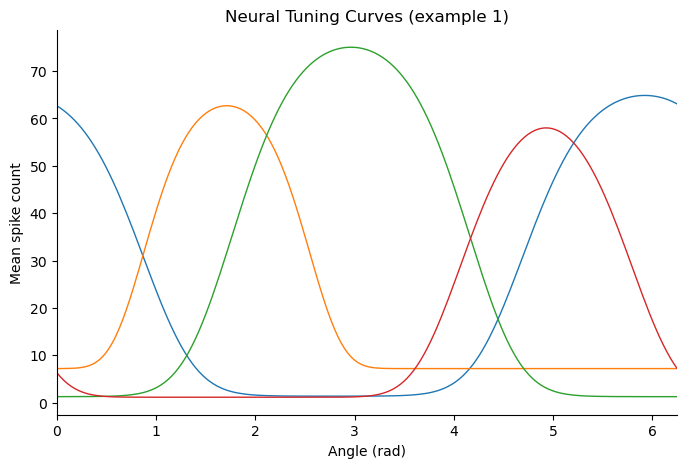

In [15]:
%%time 

# load tuning curves data
with open(dat_dir_in + title, 'rb') as rick:
    data_dict = pickle.load(rick)
bio_idx = np.where(data_dict['all_multipliers']==1.)[0][0]

# get tuning curves parameters for each example quad
tc_pms1 = get_tuning_curves_pms_in_rads(data_dict, example_quad_ix=0)
tc_pms2 = get_tuning_curves_pms_in_rads(data_dict, example_quad_ix=1)
tc_pms3 = get_tuning_curves_pms_in_rads(data_dict, example_quad_ix=2)
tc_pms4 = get_tuning_curves_pms_in_rads(data_dict, example_quad_ix=3)

# plot tuning curves for quad example 1
plt.figure(figsize=(8, 5))
plt.plot(xplot.flatten(), tuning_curve(xplot, tc_pms1).T, linewidth=1)
plt.ylabel('Mean spike count', fontsize=labelsize)
plt.xlabel('Angle (rad)', fontsize=labelsize)
plt.xlim([xplot.flatten()[0], xplot.flatten()[-1]])
plt.xticks(fontsize=labelsize)
plt.yticks(fontsize=labelsize)
plt.title(f'Neural Tuning Curves (example 1)');

## I(R;X) 
- Execution time: 3 min secs

In [16]:
%%time

NSAMP = 10000 #10000

# first quad example
ssi_quad1, mse_quad1 = compute_I_brute_force(x, xplot, tc_pms1, dx=dx, nsamp=NSAMP) 

# second quad example
ssi_quad2, mse_quad2 = compute_I_brute_force(x, xplot, tc_pms2, dx=dx, nsamp=NSAMP) 

# third quad example
ssi_quad3, mse_quad3 = compute_I_brute_force(x, xplot, tc_pms3, dx=dx, nsamp=NSAMP) 

# fourth quad example
ssi_quad4, mse_quad4 = compute_I_brute_force(x, xplot, tc_pms4, dx=dx, nsamp=NSAMP) 

I brute force: 100%|██████████| 10000/10000 [00:47<00:00, 211.60it/s]

CPU times: user 9min 27s, sys: 187 ms, total: 9min 27s
Wall time: 3min 9s


## Fisher info

In [17]:
%%time 

# first quad example
fisher_info_quad1 = compute_fisher(xplot, tuning_curve(xplot, tc_pms1)) # OK!

# second quad example
fisher_info_quad2 = compute_fisher(xplot, tuning_curve(xplot, tc_pms2)) # OK!

# third quad example
fisher_info_quad3 = compute_fisher(xplot, tuning_curve(xplot, tc_pms3)) # OK!

# fourth quad example
fisher_info_quad4 = compute_fisher(xplot, tuning_curve(xplot, tc_pms4)) # OK!

CPU times: user 2.49 ms, sys: 945 µs, total: 3.43 ms
Wall time: 1.42 ms


## Compute $I_{local}$

- Execution time: 2h

In [18]:
%%time

# first quad example
Ilocal_quad1, _, _, _, x_rates_quad1 = compute_circular_ilocal(x, xplot, fisher_info_quad1, tc_pms1, dx=dx, nsamp=NSAMP)

# second quad example
Ilocal_quad2, _, _, _, x_rates_quad2 = compute_circular_ilocal(x, xplot, fisher_info_quad2, tc_pms2, dx=dx, nsamp=NSAMP)

# third quad example
Ilocal_quad3, _, _, _, x_rates_quad3 = compute_circular_ilocal(x, xplot, fisher_info_quad3, tc_pms3, dx=dx, nsamp=NSAMP)

# fourth quad example
Ilocal_quad4, _, _, _, x_rates_quad4 = compute_circular_ilocal(x, xplot, fisher_info_quad4, tc_pms4, dx=dx, nsamp=NSAMP)

Computing Ilocal:   0%|          | 0/10000 [00:00<?, ?it/s]

Computing Ilocal: 100%|██████████| 10000/10000 [35:50<00:00,  4.65it/s]

CPU times: user 3h 46min 30s, sys: 25min 9s, total: 4h 11min 40s
Wall time: 2h 19min 10s


## Plot

/tmp/ipykernel_4123430/2090614493.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(handlelength = 0, labelcolor = 'linecolor', **legend)
/tmp/ipykernel_4123430/2090614493.py:88: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(handlelength = 0, labelcolor = 'linecolor', loc=(0.7,0.8), **legend)
/tmp/ipykernel_4123430/2090614493.py:151: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(handlelength = 0, labelcolor = 'linecolor', loc=(0.7,0.8), **legend)
/tmp/ipykernel_4123430/2090614493.py:215: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start

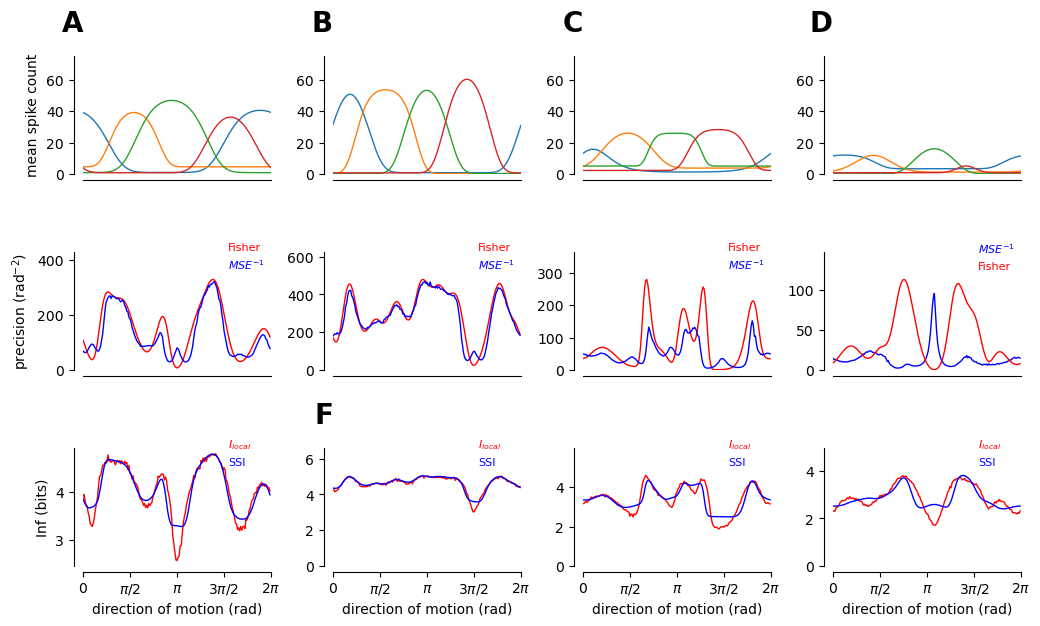

In [26]:
# setup params
legend = {'frameon': False, 'fontsize': 8}
letter_size = 20
letter_x = -0
letter_y = 1.4 # 1.5
labelsize = 10
linew = 1
ybottom = -0.1
xlim = [x.flatten()[0], x.flatten()[-1]]

# setup figure
fig, axes = plt.subplots(3,4, figsize=(10.5,6.5))

# Quad 1 -------------------------------------------------------

# Mean spike count 
ax = axes[0,0]
ax.plot(x.flatten(), x_rates_quad1.T/1.6, linewidth=linew)
# formatting
ax.set_ylabel('mean spike count', fontsize=labelsize)
ax.set_xlim(xlim)
ax.set_ylim([0, 1.2 * np.max(x_rates_quad1)])
ax.tick_params(labelsize=labelsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([])
ax.legend(handlelength = 0, labelcolor = 'linecolor', **legend)
ax.text(letter_x, letter_y, 'A', transform=ax.transAxes,
            fontsize=letter_size, fontweight='bold', va='top', ha='right')
ax.spines["bottom"].set_position(("axes", -0.05)) # disconnect axes
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))
ax.set_ylim(0,75)

# Precision 
ax = axes[1,0]
ax.plot(xplot.flatten(), fisher_info_quad1, 'r-', linewidth=linew, label='Fisher')
ax.plot(xplot.flatten(), 1/(mse_quad1.flatten() + np.finfo(float).eps), 'b-', linewidth=linew, label='$MSE^{-1}$')
# formatting
ax.set_ylabel('precision (rad$^{-2}$)', fontsize=labelsize)
ax.set_ylim([ybottom, 1.3 * np.max([np.max(fisher_info_quad1), np.max(1./(mse_quad1 + np.finfo(float).eps))])])
ax.set_xlim(xlim)
ax.tick_params(labelsize=labelsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([])
ax.legend(handlelength = 0, labelcolor = 'linecolor', loc=(0.7,0.8), **legend)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))

# Information 
ax = axes[2,0]
ax.plot(xplot.flatten(), Ilocal_quad1.flatten()/np.log(2), 'r', linewidth=linew, label='$I_{local}$')
ax.plot(xplot.flatten(), ssi_quad1.flatten()/np.log(2), 'b-', linewidth=linew, label='SSI')
# formatting
# ax.set_ylim([0, 1.3 * np.max(Ilocal_quad1)/np.log(2)])
ax.set_xlim(xlim)
ax.tick_params(labelsize=labelsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
xtick_positions = np.linspace(xlim[0], xlim[1], 5)
xtick_labels = np.linspace(xlim[0], xlim[1], 5)
ax.set_xticks(xtick_positions)
ax.set_xticklabels([f'{label:.0f}' for label in xtick_labels])
ax.legend(handlelength = 0, labelcolor = 'linecolor', loc=(0.7,0.8), **legend)
ax.set_ylabel('Inf (bits)', fontsize=labelsize)
ax.set_xlabel('direction of motion (rad)', fontsize=labelsize)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))
ax.set_xticklabels(['$0$', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])


# Quad 2 -------------------------------------------------------

# Mean spike count 
ax = axes[0,1]
ax.plot(x.flatten(), x_rates_quad2.T/1.6, linewidth=linew)
# formatting
ax.set_xlim(xlim)
ax.set_ylim([0, 1.2 * np.max(x_rates_quad2)])
ax.tick_params(labelsize=labelsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([])
# ax.legend(handlelength = 0, labelcolor = 'linecolor', **legend, loc=(0.01, 0.75))
ax.legend(handlelength = 0, labelcolor = 'linecolor', loc=(0.7,0.8), **legend)
ax.text(letter_x, letter_y, 'B', transform=ax.transAxes,
            fontsize=letter_size, fontweight='bold', va='top', ha='right')
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))
ax.set_ylim(0,75) 

# Precision
ax = axes[1,1]
ax.plot(xplot.flatten(), fisher_info_quad2, 'r-', linewidth=linew, label='Fisher')
ax.plot(xplot.flatten(), 1/(mse_quad2.flatten() + np.finfo(float).eps), 'b-', linewidth=linew, label='$MSE^{-1}$')
# formatting
ax.set_ylim([ybottom, 1.3 * np.max([np.max(fisher_info_quad2), np.max(1./(mse_quad2 + np.finfo(float).eps))])])
ax.set_xlim(xlim)
ax.tick_params(labelsize=labelsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([])
# ax.legend(handlelength = 0, labelcolor = 'linecolor', loc=(0.5, 0.75), **legend)
ax.legend(handlelength = 0, labelcolor = 'linecolor', loc=(0.7,0.8), **legend)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))


# Information
ax = axes[2,1]
ax.plot(xplot.flatten(), Ilocal_quad2.flatten()/np.log(2), 'r', linewidth=linew, label='$I_{local}$')
ax.plot(xplot.flatten(), ssi_quad2.flatten()/np.log(2), 'b-', linewidth=linew, label='SSI')
# formatting
ax.set_ylim([0, 1.3 * np.max(Ilocal_quad2)/np.log(2)])
ax.set_xlim(xlim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
xtick_positions = np.linspace(xlim[0],xlim[1], 5)
xtick_labels = np.linspace(xlim[0],xlim[1], 5)
ax.set_xticks(xtick_positions)
ax.set_xticklabels([f'{label:.0f}' for label in xtick_labels])
# ax.legend(handlelength = 0, labelcolor = 'linecolor', bbox_to_anchor=(0.3,0.67), **legend)
ax.legend(handlelength = 0, labelcolor = 'linecolor', loc=(0.7,0.8), **legend)
ax.set_xlabel('direction of motion (rad)', fontsize=labelsize)
ax.tick_params(labelsize=labelsize)
ax.text(letter_x, letter_y, 'F', transform=ax.transAxes,
            fontsize=letter_size, fontweight='bold', va='top', ha='right')
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))
ax.set_xticklabels(['$0$', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])


#  Quad 3 -------------------------------------------------------

# Mean spike count 
ax = axes[0,2]
ax.plot(x.flatten(), x_rates_quad3.T/1.6, linewidth=linew)
# formatting
ax.set_xlim(xlim)
# ax.set_ylim([0, 1.2 * np.max(x_rates_quad3)])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([])
# ax.legend(handlelength = 0, labelcolor = 'linecolor', **legend)
ax.legend(handlelength = 0, labelcolor = 'linecolor', loc=(0.7,0.8), **legend)
ax.tick_params(labelsize=labelsize)
ax.text(letter_x, letter_y, 'C', transform=ax.transAxes,
            fontsize=letter_size, fontweight='bold', va='top', ha='right')
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))
ax.set_ylim(0,75) 

# Precision
ax = axes[1,2]
ax.plot(xplot.flatten(), fisher_info_quad3, 'r-', linewidth=linew, label='Fisher')
ax.plot(xplot.flatten(), 1/(mse_quad3.flatten() + np.finfo(float).eps), 'b-', linewidth=linew, label='$MSE^{-1}$')
# formatting
ax.set_ylim([ybottom, 1.3 * np.max([np.max(fisher_info_quad3), np.max(1./(mse_quad3 + np.finfo(float).eps))])])
ax.set_xlim(xlim)
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.legend(handlelength = 0, labelcolor = 'linecolor', **legend, loc=(0.01, 0.75))
ax.legend(handlelength = 0, labelcolor = 'linecolor', loc=(0.7,0.8), **legend)
ax.tick_params(labelsize=labelsize)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))


# Information
ax = axes[2,2]
ax.plot(xplot.flatten(), Ilocal_quad3.flatten()/np.log(2), 'r', linewidth=linew, label='$I_{local}$')
ax.plot(xplot.flatten(), ssi_quad3.flatten()/np.log(2), 'b-', linewidth=linew, label='SSI')
ax.legend(handlelength = 0, labelcolor = 'linecolor', **legend, bbox_to_anchor=(-1, 0.4))
# formatting
ax.set_ylim([0, 1.3 * np.max(Ilocal_quad3)/np.log(2)])
ax.set_xlim(xlim)
ax.tick_params(labelsize=labelsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
xtick_positions = np.linspace(xlim[0],xlim[1], 5)
xtick_labels = np.linspace(xlim[0],xlim[1], 5)
ax.set_xticks(xtick_positions)
ax.set_xticklabels([f'{label:.0f}' for label in xtick_labels])
ax.tick_params(labelsize=labelsize)
# ax.legend(handlelength = 0, labelcolor = 'linecolor', **legend)
ax.legend(handlelength = 0, labelcolor = 'linecolor', loc=(0.7,0.8), **legend)
ax.set_xlabel('direction of motion (rad)', fontsize=labelsize)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))
ax.set_xticklabels(['$0$', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])


# Quad 4 -------------------------------------------------------

# Mean spike count 
ax = axes[0,3]
ax.plot(x.flatten(), x_rates_quad4.T/1.6, linewidth=linew)
# formatting
ax.set_xlim(xlim)
ax.set_ylim([0, 1.2 * np.max(x_rates_quad4)])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([])
# ax.legend(handlelength = 0, labelcolor = 'linecolor', **legend)
ax.legend(handlelength = 0, labelcolor = 'linecolor', loc=(0.7,0.8), **legend)
ax.tick_params(labelsize=labelsize)
ax.text(letter_x, letter_y, 'D', transform=ax.transAxes,
            fontsize=letter_size, fontweight='bold', va='top', ha='right')
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))
ax.set_ylim(0,75) 

# Precision
ax = axes[1,3]
ax.plot(xplot.flatten(), 1/(mse_quad4.flatten() + np.finfo(float).eps), 'b-', linewidth=linew, label='$MSE^{-1}$')
ax.plot(xplot.flatten(), fisher_info_quad4, 'r-', linewidth=linew, label='Fisher')
# formatting
ax.set_ylim([
    ybottom,
    1.3 * max(
        np.max(fisher_info_quad4),
        np.max(1. / (mse_quad4 + np.finfo(float).eps)),
    )
])
ax.set_xlim(xlim)
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.legend(labelcolor='linecolor', bbox_to_anchor=(1,1.1), **legend)
ax.legend(handlelength = 0, labelcolor = 'linecolor', loc=(0.7,0.8), **legend)
ax.tick_params(labelsize=labelsize)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))

# Information
ax = axes[2,3]
ax.plot(xplot.flatten(), Ilocal_quad4.flatten()/np.log(2), 'r-', linewidth=linew, label='$I_{local}$')
ax.plot(xplot.flatten(), ssi_quad4.flatten()/np.log(2), 'b-', linewidth=linew, label='SSI')
# formatting
ax.set_ylim([
    0,
    max(
        1.3 * np.max(Ilocal_quad4) / np.log(2),
        1.3 * np.max(ssi_quad4.flatten()) / np.log(2)
    )
])
ax.set_xlim(xlim)
ax.tick_params(labelsize=labelsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
xtick_positions = np.linspace(xlim[0],xlim[1], 5)
xtick_labels = np.linspace(xlim[0], xlim[1], 5)
ax.set_xticks(xtick_positions)
ax.set_xticklabels([f'{label:.0f}' for label in xtick_labels])
# ax.legend(labelcolor = 'linecolor', **legend)
ax.legend(handlelength = 0, labelcolor = 'linecolor', loc=(0.7,0.8), **legend)
ax.set_xlabel('direction of motion (rad)', fontsize=labelsize)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))
ax.set_xticklabels(['$0$', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])

# formatting
fig.tight_layout(h_pad=0.8) 

# save figure
plt.savefig('figures/fig2.svg', dpi=300, bbox_inches='tight', transparent=True)
plt.savefig('figures/fig2.pdf', dpi=300, bbox_inches='tight', transparent=True)

## Controls $E[I_{local}]=E[ssi]$

In [20]:
# ensure the expected ilocal and ssi are equal
print("quad 1")
print(Ilocal_quad1.mean())
print(ssi_quad1.mean())

print("\nquad 2:")
print(Ilocal_quad2.mean())
print(ssi_quad2.mean())

print("\nquad 3:")
print(Ilocal_quad3.mean())
print(ssi_quad3.mean())

print("\nquad 4:")
print(Ilocal_quad4.mean())
print(ssi_quad4.mean())

quad 1
2.8003155792107854
2.7987193165335813

quad 2:
3.1979523042301823
3.219370866905399

quad 3:
2.3487931366653965
2.3551870826378183

quad 4:
2.0002438971308507
1.9831052981910184


In [21]:
# TODO: add correlation between fisher and 1/MSE orange distribution